In [1]:
# import neccesary datasets
# 10 = ravdess
# 11 = crema - db
# 12 - EmoDB


In [3]:
import os
import zipfile

# Path to the directory containing your ZIP files
zip_dir = 'zipfolder'

# List all ZIP files in the directory
for filename in os.listdir(zip_dir):
    if filename.endswith('.zip'):
        zip_path = os.path.join(zip_dir, filename)
        
        # Use the ZIP file's name (without extension) as the folder name
        folder_name = os.path.splitext(filename)[0]
        extract_path = os.path.join(zip_dir, folder_name)
        os.makedirs(extract_path, exist_ok=True)
        
        # Extract to the created folder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f'Extracted {filename} to {extract_path}')


Extracted archive (10).zip to zipfolder\archive (10)
Extracted archive (11).zip to zipfolder\archive (11)
Extracted archive (12).zip to zipfolder\archive (12)


In [4]:
import os
import librosa
import numpy as np
import pandas as pd

BASE_DIR = "zipfolder"

# Paths for each dataset
RAVDESS_PATH = os.path.join(BASE_DIR, "archive (10)")
CREMA_PATH   = os.path.join(BASE_DIR, "archive (11)")
EMODB_PATH   = os.path.join(BASE_DIR, "archive (12)")

# Helper function to extract MFCC features
def extract_mfcc(file_path):
    """Extracts 40 MFCC features from a given audio file."""
    try:
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        print(f"⚠️ Error reading {file_path}: {e}")
        return None

In [5]:
# ------------------------- #
# 🎭 1. RAVDESS Dataset
# ------------------------- #
def process_ravdess(path):
    """Processes the RAVDESS dataset."""
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

    data = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                emotion_code = file.split("-")[2]
                emotion = emotion_map.get(emotion_code, "unknown")
                features = extract_mfcc(os.path.join(root, file))
                if features is not None:
                    data.append([features, emotion])

    return pd.DataFrame(data, columns=["features", "emotion"])

In [6]:
# ------------------------- #
# 🎙 2. CREMA-D Dataset
# ------------------------- #
def process_crema(path):
    """Processes the CREMA-D dataset."""
    data = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                try:
                    # Example: 1001_DFA_ANG_XX.wav → ANG = angry
                    emotion_code = file.split("_")[2]
                    emotion = emotion_code.lower()
                    features = extract_mfcc(os.path.join(root, file))
                    if features is not None:
                        data.append([features, emotion])
                except Exception as e:
                    print(f"⚠️ Error in {file}: {e}")

    return pd.DataFrame(data, columns=["features", "emotion"])



In [7]:
# ------------------------- #
# 🎧 3. Emo-DB Dataset
# ------------------------- #
def process_emodb(path):
    """Processes the Emo-DB dataset."""
    emo_dict = {
        'W': 'angry', 'L': 'boredom', 'E': 'disgust',
        'A': 'fear', 'F': 'happy', 'T': 'sad', 'N': 'neutral'
    }

    data = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                try:
                    emotion = emo_dict.get(file[5].upper(), "unknown")
                    features = extract_mfcc(os.path.join(root, file))
                    if features is not None:
                        data.append([features, emotion])
                except Exception as e:
                    print(f"⚠️ Error in {file}: {e}")

    return pd.DataFrame(data, columns=["features", "emotion"])

In [10]:
ravdess_df = process_ravdess(RAVDESS_PATH)
print(f"✅ RAVDESS: {len(ravdess_df)} samples")

✅ RAVDESS: 2880 samples


In [11]:
crema_df = process_crema(CREMA_PATH)
print(f" CREMA-D: {len(crema_df)} samples")

 CREMA-D: 7442 samples


In [12]:
print("\nProcessing Emo-DB dataset...")
emodb_df = process_emodb(EMODB_PATH)
print(f"✅ Emo-DB: {len(emodb_df)} samples")


Processing Emo-DB dataset...
✅ Emo-DB: 535 samples


In [13]:
# saving them separately 
ravdess_df.to_pickle("ravdess_features.pkl")
crema_df.to_pickle("crema_features.pkl")
emodb_df.to_pickle("emodb_features.pkl")

print(" All three DataFrames saved successfully!")

 All three DataFrames saved successfully!


In [15]:
ravdess_df['emotion'].value_counts()

emotion
calm         384
happy        384
sad          384
angry        384
fearful      384
disgust      384
surprised    384
neutral      192
Name: count, dtype: int64

In [16]:
crema_df['emotion'].value_counts()

emotion
ang    1271
dis    1271
fea    1271
hap    1271
sad    1271
neu    1087
Name: count, dtype: int64

In [17]:
emodb_df['emotion'].value_counts()

emotion
angry      127
boredom     81
neutral     79
happy       71
fear        69
sad         62
disgust     46
Name: count, dtype: int64

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


ravdess_df = pd.read_pickle("ravdess_features.pkl")
crema_df = pd.read_pickle("crema_features.pkl")
emodb_df = pd.read_pickle("emodb_features.pkl")

print(f"RAVDESS: {len(ravdess_df)} | CREMA-D: {len(crema_df)} | Emo-DB: {len(emodb_df)}")


# Combine all DataFrames

all_data = pd.concat([ravdess_df, crema_df, emodb_df], ignore_index=True)
print(f"\nTotal combined samples: {len(all_data)}")

# Remove unknown emotions if any
all_data = all_data[all_data["emotion"] != "unknown"]

# ------------------------- #
# ⚙️ Prepare features (X) and labels (y)
# ------------------------- #
X = np.array(all_data["features"].tolist())
y = np.array(all_data["emotion"].tolist())

# Encode emotions into numbers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Reshape X for LSTM = (samples, timesteps, features)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


#  Build the LSTM Model

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(y_onehot.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


# 🚀 Train the Model
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


# 📊 Evaluate Model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")


# 💾 Save Model
model.save("emotion_recognition_model.h5")
print("💾 Model saved as 'emotion_recognition_model.h5'")


RAVDESS: 2880 | CREMA-D: 7442 | Emo-DB: 535

Total combined samples: 10857
X_train shape: (8685, 40, 1)
y_train shape: (8685, 15)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 299,023
Trainable params: 299,023
Non-traina

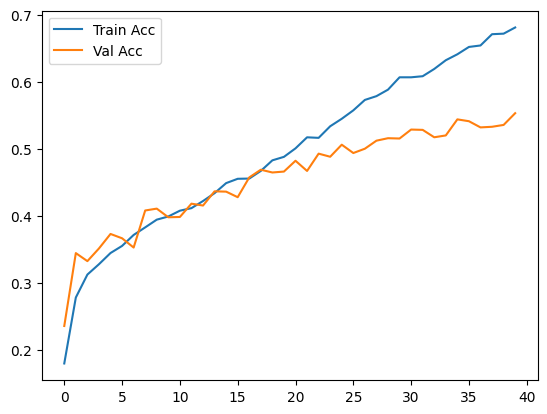

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.show()


In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


ravdess_df = pd.read_pickle("ravdess_features.pkl")
crema_df = pd.read_pickle("crema_features.pkl")
emodb_df = pd.read_pickle("emodb_features.pkl")

print(f"RAVDESS: {len(ravdess_df)} | CREMA-D: {len(crema_df)} | Emo-DB: {len(emodb_df)}")


# ⚖️ Balance Datasets

min_len = min(len(ravdess_df), len(crema_df), len(emodb_df))
ravdess_df = ravdess_df.sample(min_len, random_state=42)
crema_df = crema_df.sample(min_len, random_state=42)
emodb_df = emodb_df.sample(min_len, random_state=42)

all_data = pd.concat([ravdess_df, crema_df, emodb_df], ignore_index=True)
print(f"\nBalanced total samples: {len(all_data)}")


#  Prepare features (X) and labels (y)

X = np.array(all_data["features"].tolist())
y = np.array(all_data["emotion"].tolist())

# Ensure proper shape
print(f"Original feature shape: {X.shape}")

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.expand_dims(X, -1)  
# shape: (samples, timesteps, 1)
print(f"Expanded X shape: {X.shape}")

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")


# 🧠 Build Improved BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(128)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# ✅ Manually build the model before summary
model.build(input_shape=(None, X_train.shape[1], 1))
model.summary()

#  Compile & Callbacks
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


# 🚀 Train Model
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


# 📊 Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# 💾 Save Model
model.save("emotion_recognition_bilstm_fixed.h5")
print("💾 Model saved as 'emotion_recognition_bilstm_fixed.h5'")


RAVDESS: 2880 | CREMA-D: 7442 | Emo-DB: 535

Balanced total samples: 1605
Original feature shape: (1605, 40)
Expanded X shape: (1605, 40, 1)
✅ X_train: (1284, 40, 1), y_train: (1284, 15)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 40, 512)          528384    
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 40, 512)          2048      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 40, 512)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              656384    
 nal)                                                            

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Dropout, Conv1D, MaxPooling1D,
    Bidirectional, BatchNormalization, Attention, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


ravdess_df = pd.read_pickle("ravdess_features.pkl")
crema_df = pd.read_pickle("crema_features.pkl")
emodb_df = pd.read_pickle("emodb_features.pkl")

print(f"RAVDESS: {len(ravdess_df)} | CREMA-D: {len(crema_df)} | Emo-DB: {len(emodb_df)}")


min_len = min(len(ravdess_df), len(crema_df), len(emodb_df))
ravdess_df = ravdess_df.sample(min_len, random_state=42)
crema_df = crema_df.sample(min_len, random_state=42)
emodb_df = emodb_df.sample(min_len, random_state=42)

all_data = pd.concat([ravdess_df, crema_df, emodb_df], ignore_index=True)
print(f"\nBalanced total samples: {len(all_data)}")

# ------------------------- #
# ⚙️ Prepare Features (X) and Labels (y)
# ------------------------- #
X = np.array(all_data["features"].tolist())
y = np.array(all_data["emotion"].tolist())

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.expand_dims(X, -1)  # shape: (samples, timesteps, 1)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")


# 🧠 Build CNN + BiLSTM + Attention Model

inp = Input(shape=(X_train.shape[1], 1))

# CNN feature extraction
x = Conv1D(128, 3, padding='same', activation='relu')(inp)
x = MaxPooling1D(2)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# BiLSTM temporal learning
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = BatchNormalization()(x)

# Self-Attention mechanism
attention = Attention()([x, x])
x = Flatten()(attention)
x = Dropout(0.3)(x)

# Dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

optimizer = Adam(learning_rate=0.0003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()


#  Training Setup

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]


# 🚀 Train the Model
#
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


# 📊 Evaluate
# ------------------------- #
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")


# 💾 Save Model
model.save("emotion_recognition_cnn_bilstm_attention.h5")
print("💾 Model saved as 'emotion_recognition_cnn_bilstm_attention.h5'")


RAVDESS: 2880 | CREMA-D: 7442 | Emo-DB: 535

Balanced total samples: 1605
X_train: (1284, 40, 1), y_train: (1284, 15)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 40, 128)      512         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 20, 128)      0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 20, 128)     512         ['max_pool

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os

# ---------------------------- #
# 🧩 Utility Functions
# ---------------------------- #
def prepare_data(df):
    X = np.array(df["features"].tolist())
    y = np.array(df["emotion"].tolist())
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = np.expand_dims(X, -1)
    
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)
    
    return X, y_onehot, encoder, scaler


def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(128, 3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0003),
        metrics=['accuracy']
    )
    return model


def train_and_evaluate(df, name):
    print(f"\n🎵 Training model for {name} dataset")
    X, y, encoder, scaler = prepare_data(df)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = build_model((X_train.shape[1], 1), y_train.shape[1])
    model.summary()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ {name} Accuracy: {acc:.2f}")
    
    model.save(f"emotion_model_{name.lower()}.h5")
    print(f"💾 Saved as emotion_model_{name.lower()}.h5")
    
    return model, acc


# ---------------------------- #
# 🧠 Load Datasets
# ---------------------------- #
ravdess_df = pd.read_pickle("ravdess_features.pkl")
crema_df = pd.read_pickle("crema_features.pkl")
emodb_df = pd.read_pickle("emodb_features.pkl")

print(f"RAVDESS: {len(ravdess_df)} | CREMA-D: {len(crema_df)} | Emo-DB: {len(emodb_df)}")

# Optional: trim large datasets to balance compute
min_len = min(len(ravdess_df), len(crema_df), len(emodb_df))
ravdess_df = ravdess_df.sample(min_len, random_state=42)
crema_df = crema_df.sample(min_len, random_state=42)
emodb_df = emodb_df.sample(min_len, random_state=42)

# ---------------------------- #
# 🚀 Train on Each Dataset
# ---------------------------- #
ravdess_model, rav_acc = train_and_evaluate(ravdess_df, "RAVDESS")
crema_model, crema_acc = train_and_evaluate(crema_df, "CREMA")
emodb_model, emodb_acc = train_and_evaluate(emodb_df, "EMODB")

print("\n📊 Individual Results:")
print(f"RAVDESS: {rav_acc:.2f} | CREMA-D: {crema_acc:.2f} | EMODB: {emodb_acc:.2f}")

# ---------------------------- #
# 🌍 Unified Fine-Tuning (Optional)
# ---------------------------- #
print("\n🔄 Fine-tuning unified model...")

# Combine all data again for fine-tuning
all_data = pd.concat([ravdess_df, crema_df, emodb_df], ignore_index=True)
X, y, encoder, scaler = prepare_data(all_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start from the best performing model (CREMA often has best coverage)
model = build_model((X_train.shape[1], 1), y_train.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🌍 Unified Model Accuracy: {acc:.2f}")

model.save("emotion_model_unified.h5")
print("💾 Saved as emotion_model_unified.h5")


RAVDESS: 2880 | CREMA-D: 7442 | Emo-DB: 535

🎵 Training model for RAVDESS dataset
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 40, 128)           512       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 128)          0         
 1D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 20, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 20, 128)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 256)          263168    
 nal)                                 

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os


def prepare_data(df):
    """Prepare features and labels"""
    X = np.array(df["features"].tolist())
    y = np.array(df["emotion"].tolist())

    # Scale and reshape
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = np.expand_dims(X, -1)

    # Encode labels
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)

    return X, y_onehot, encoder, scaler


def build_model(input_shape, num_classes):
    """Define CNN + BiLSTM architecture"""
    model = Sequential([
        Conv1D(128, 3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0003),
        metrics=['accuracy']
    )
    return model


def train_dataset(df, name):
    """Train and evaluate model for one dataset"""
    print(f"\n🎵 Training model for {name} dataset")

    X, y, encoder, scaler = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model((X_train.shape[1], 1), y_train.shape[1])
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=60,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ {name} Test Accuracy: {acc:.2f}")

    model.save(f"emotion_model_sep_{name.lower()}.h5")
    print(f"💾 Model saved as emotion_model_{name.lower()}.h5")

    return model, acc


print(" Loading  three datasets")

ravdess_df = pd.read_pickle("ravdess_features.pkl")
crema_df = pd.read_pickle("crema_features.pkl")
emodb_df = pd.read_pickle("emodb_features.pkl")

print(f"RAVDESS: {len(ravdess_df)} | CREMA-D: {len(crema_df)} | EMODB: {len(emodb_df)}")


# 🚀 Train 3 Separate Models
ravdess_model, rav_acc = train_dataset(ravdess_df, "RAVDESS")
crema_model, crema_acc = train_dataset(crema_df, "CREMA-D")
emodb_model, emodb_acc = train_dataset(emodb_df, "EMODB")


# 📊 Summary of Results
print("\n==============================")
print("📈 Final Model Accuracies:")
print(f"🎤 RAVDESS : {rav_acc:.2f}")
print(f"🎧 CREMA-D : {crema_acc:.2f}")
print(f"🎙️ EMODB   : {emodb_acc:.2f}")
print("==============================")

print("\n✅ All models trained and saved successfully.")


 Loading  three datasets
RAVDESS: 2880 | CREMA-D: 7442 | EMODB: 535

🎵 Training model for RAVDESS dataset
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 40, 128)           512       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 20, 128)          0         
 1D)                                                             
                                                                 
 batch_normalization_14 (Bat  (None, 20, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 20, 128)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 20, 256)          263168    
 nal)         


📦 Evaluating RAVDESS model...
✅ Accuracy on RAVDESS: 0.97
18/18 [==============================] - 1s 11ms/step

📋 Classification Report for RAVDESS:
              precision    recall  f1-score   support

       angry       1.00      0.92      0.96        79
        calm       0.97      1.00      0.99        69
     disgust       0.93      0.98      0.95        84
     fearful       1.00      0.95      0.97        80
       happy       0.95      1.00      0.98        82
     neutral       0.95      0.95      0.95        42
         sad       0.97      0.97      0.97        61
   surprised       0.95      0.95      0.95        79

    accuracy                           0.97       576
   macro avg       0.97      0.96      0.96       576
weighted avg       0.97      0.97      0.97       576



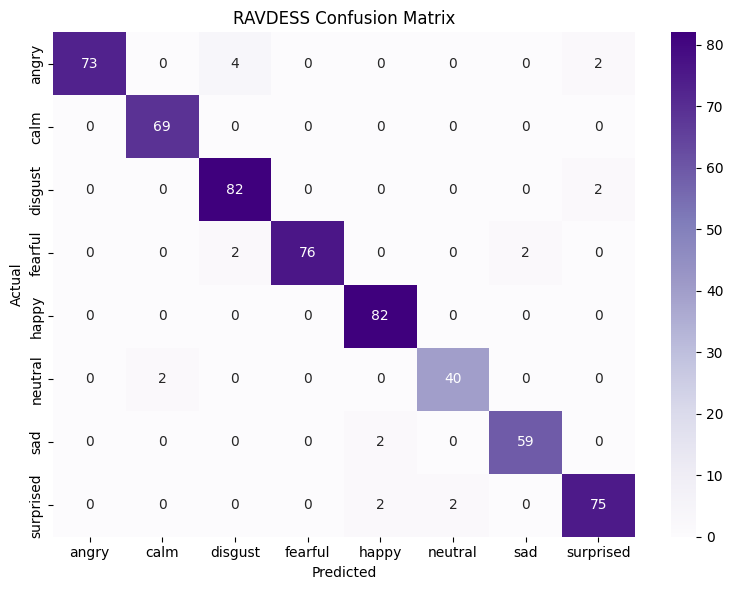


📦 Evaluating CREMA-D model...
✅ Accuracy on CREMA-D: 0.51
47/47 [==============================] - 1s 7ms/step

📋 Classification Report for CREMA-D:
              precision    recall  f1-score   support

         ang       0.64      0.73      0.68       235
         dis       0.43      0.37      0.40       269
         fea       0.47      0.36      0.41       239
         hap       0.47      0.35      0.40       260
         neu       0.44      0.57      0.50       224
         sad       0.55      0.68      0.61       262

    accuracy                           0.51      1489
   macro avg       0.50      0.51      0.50      1489
weighted avg       0.50      0.51      0.50      1489



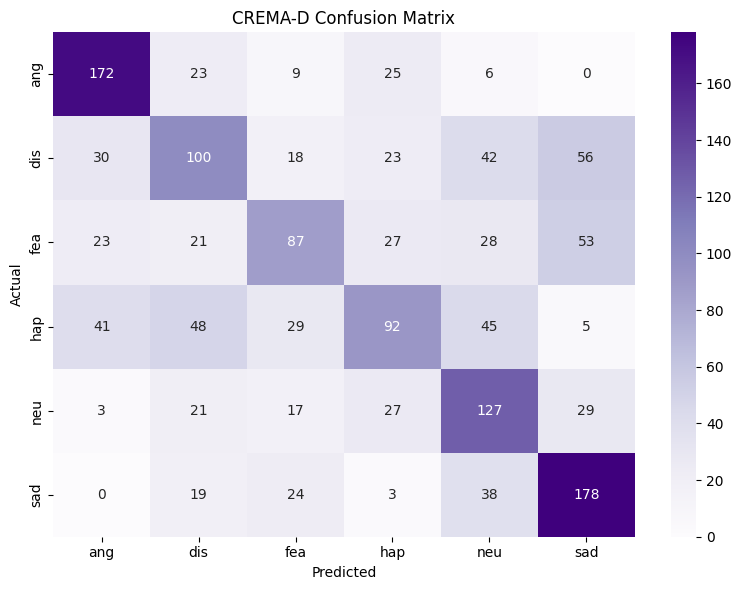


📦 Evaluating EMODB model...
✅ Accuracy on EMODB: 0.83
4/4 [==============================] - 1s 10ms/step

📋 Classification Report for EMODB:
              precision    recall  f1-score   support

       angry       0.93      0.78      0.85        18
     boredom       0.93      0.70      0.80        20
     disgust       0.82      0.75      0.78        12
        fear       0.81      0.93      0.87        14
       happy       0.78      0.78      0.78        18
     neutral       0.70      1.00      0.82        16
         sad       1.00      1.00      1.00         9

    accuracy                           0.83       107
   macro avg       0.85      0.85      0.84       107
weighted avg       0.85      0.83      0.83       107



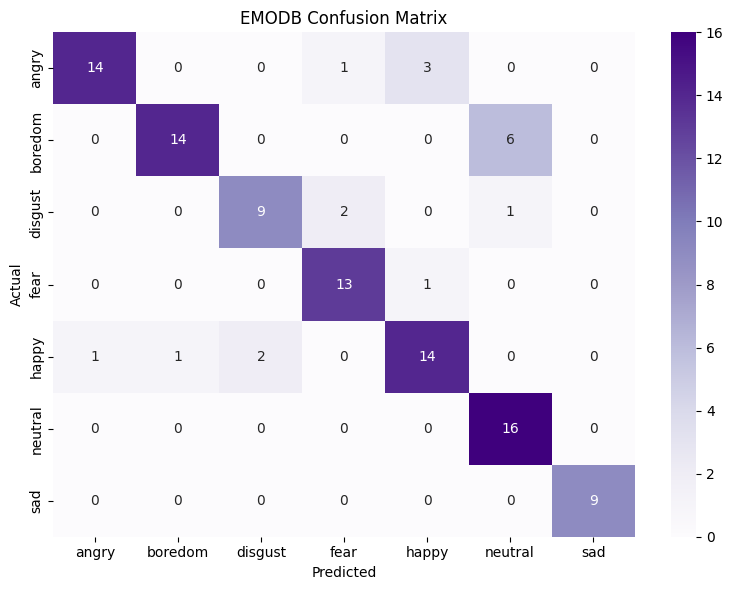

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# ------------------------------ #
# 🧩 Data Preparation Function
# ------------------------------ #
def prepare_data(df):
    X = np.array(df["features"].tolist())
    y = np.array(df["emotion"].tolist())

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = np.expand_dims(X, -1)

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)

    return X, y_onehot, encoder


# ------------------------------ #
# 📊 Evaluation Function
# ------------------------------ #
def evaluate_model(model_path, df, dataset_name):
    print(f"\n📦 Evaluating {dataset_name} model...")
    model = load_model(model_path)

    X, y, encoder = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ Accuracy on {dataset_name}: {acc:.2f}")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Classification report
    print(f"\n📋 Classification Report for {dataset_name}:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{dataset_name}_confusion_matrix.png")
    plt.show()


# ------------------------------ #
# 🧠 Load Data
# ------------------------------ #
ravdess_df = pd.read_pickle("ravdess_features.pkl")
crema_df = pd.read_pickle("crema_features.pkl")
emodb_df = pd.read_pickle("emodb_features.pkl")

# ------------------------------ #
# 🧪 Evaluate All Trained Models
# ------------------------------ #
evaluate_model("emotion_model_sep_ravdess.h5", ravdess_df, "RAVDESS")
evaluate_model("emotion_model_sep_crema-d.h5", crema_df, "CREMA-D")
evaluate_model("emotion_model_sep_emodb.h5", emodb_df, "EMODB")


In [21]:
import tensorflow as tf
print(tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


2.9.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
